In [2]:
!pwd

/content


In [2]:
%cd drive/My Drive/nlp-telugu


/content/drive/My Drive/nlp-telugu


In [3]:
!pwd

/content/drive/My Drive/nlp-telugu


In [ ]:
import fastai, torch

In [5]:
fastai.__version__ , torch.__version__

('1.0.60', '1.4.0')

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re

In [ ]:
df = pd.read_csv('drive/My Drive/nlp-telugu/inltk/dataset/telugu_wiki_links.csv')
unique_links = df['link'].values

In [ ]:
def readout_buffer(response):
    response.text = response.read()
    return response.text.decode('utf-8')

    
def get_data_from_url(url):
    try:
        r = urlopen(url)
        doc = readout_buffer(r)
    except Exception as e:
        # print(e)
        doc = ""
    return doc

In [10]:
!pip install selectolax
from selectolax.parser import HTMLParser
def get_details(url):
    doc = get_data_from_url(url)
    try: 
        html_doc = HTMLParser(doc)
        t = '\n '.join(n.text() for n in html_doc.css("title"))
        a = '\n '.join(n.text() for n in html_doc.css("p"))
    except:
        t = ""
        a = ""
    return t, a

In [11]:
from datetime import datetime
import multiprocessing as mp
import multiprocessing.dummy as mpd
import time

start = datetime.now()
cpu_cores = mp.cpu_count()
print('parallelising the task on {} cpu cores'.format(cpu_cores))

rows = []
count = 0
# divide pool
pool = mpd.Pool(processes=cpu_cores)
# iter over 
for row in pool.imap(get_details, unique_links):
    rows.append(row)    
    count = count + 1
    # print/save
    if not count%100:
        print('done for,', count)
    if not count%10000:
        df = pd.DataFrame(rows, columns = ['title', 'text'])
        df.to_parquet('telugu_wikipedia_dataset.parquet', index = None)
        print("Done for {} rows ---> {}".format(count, datetime.now() - start))
# close the pool
pool.close()
pool.join()


parallelising the task on 2 cpu cores
done for, 100
done for, 200
done for, 300
done for, 400
done for, 500
done for, 600
done for, 700
done for, 800
done for, 900
done for, 1000
done for, 1100
done for, 1200
done for, 1300
done for, 1400
done for, 1500
done for, 1600
done for, 1700
done for, 1800
done for, 1900
done for, 2000
done for, 2100
done for, 2200
done for, 2300
done for, 2400
done for, 2500
done for, 2600
done for, 2700
done for, 2800
done for, 2900
done for, 3000
done for, 3100
done for, 3200
done for, 3300
done for, 3400
done for, 3500
done for, 3600
done for, 3700
done for, 3800
done for, 3900
done for, 4000
done for, 4100
done for, 4200
done for, 4300
done for, 4400
done for, 4500
done for, 4600
done for, 4700
done for, 4800
done for, 4900
done for, 5000
done for, 5100
done for, 5200
done for, 5300
done for, 5400
done for, 5500
done for, 5600
done for, 5700
done for, 5800
done for, 5900
done for, 6000
done for, 6100
done for, 6200
done for, 6300
done for, 6400
done for, 6

In [ ]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 2.7MB/s 


In [4]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.60', '1.4.0')

In [ ]:
df = pd.read_parquet('drive/My Drive/nlp-telugu/telugu_wikipedia_dataset.parquet')

In [6]:
df.shape, df.columns

((90000, 2), Index(['title', 'text'], dtype='object'))

In [7]:
texts = (df['title'] + ' ' + df['text']).tolist()
texts = [t for t in df['text'] if len(t.strip())>1]
print(len(texts))

83953


In [ ]:
df2 = pd.DataFrame(texts, columns = ['text'])

In [9]:
del df, texts
gc.collect()

0

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df2, test_size=0.2)
train_df.shape, test_df.shape

((67162, 1), (16791, 1))

In [ ]:
from inltk.tokenizer import TeluguTokenizer

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [ ]:
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')

In [14]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [ ]:
torch.cuda.set_device(0)

In [16]:
data_lm = TextLMDataBunch.from_df('/content/', train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_lm.data')


In [17]:
data_lm.batch_size

96

In [18]:
data_lm.show_batch()

idx,text
0,"▁అతనిని ▁రోడ్డు కు ▁ఈ డ్ చి ▁తక్షణ ▁న్యాయ ము ▁కోరుతూ , ▁నగ్న ంగా ▁ఏడు ▁కిలోమీటర్ల ▁దూరం ▁వరకూ ▁ఊరేగించ ి ▁రాళ్ళ తో ▁కొట్టి ▁హతమార్చ ి , ▁బహిరంగ ▁ప్రదర్శన ▁చేస్తూ ▁శవాన్ని ▁ఈ డ్ చు కెళ్ళ ి ▁ఒక ▁గో పురానికి ▁వ్రేలాడ దీ సిన ▁వై నం .[2] ▁భారతదేశంలో ▁స్త్రీల ▁పై ▁పెరిగి పో తో న్న ▁అత్యాచార ాలు , ▁2012 ▁ఢిల్లీ ▁సామూహిక ▁అత్యాచార ▁ఉద ంత ం ▁ఆధారంగా ▁చిత్రీకరించ బడ్డ ▁లఘు ▁చిత్రం ▁ఇండియా స్ ▁డా టర్ ▁పై"
1,"▁"" ▁విటమిన్ ▁ఎక్కువ ▁ . ▁ఇన్ ▁ప్ల మే షన్ ▁తగ్గించ డము లో ▁బాగా ▁దోహదపడ ుతుంది . ▁అయితే ▁మిగతా ▁వి ట మి టన్ ▁సి ▁ఉన్న ▁ఆహార పదార్ధాల ు ▁అస్ త్ మా కి ▁మంచి ▁చేయ వు ▁ . ▁రెడ్ ▁మి రి ప కాయ లోని ▁ఎస్ కార్ బి క్ ▁యాసిడ్ ▁"" ▁ఫాస్ఫ ో డి ల్ ▁స్టె రేజ్ ▁"" ▁అనే ▁ఎంజైమ్ ▁ఉ త పత్తి ని ▁అడ్డ ుకుంటుంది . ▁చాలా ▁ఆస్ త్ మా ▁మందుల లో"
2,"వి ▁గురించి ▁పూర్తిగా ▁తెలప ండి ▁x x bo s ▁ఈ ▁చిత్రం ▁ద్వారా ▁జ మున ▁తొలిసారిగా ▁వెండితెర కు ▁పరిచయ మయ్యింది . ▁x x bo s ▁ సమ్మ ట గిరి , ▁కర్నూలు ▁జిల్లా , ▁హో ళ గు ంద ▁మండలానికి ▁చెందిన ▁గ్రామం .[1] ▁ఇది ▁మండల ▁కేంద్రమైన ▁హో ళ గు ంద ▁నుండి ▁5 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁ఆదోని ▁నుండి ▁50 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది . ▁2011 ▁భారత"
3,. ▁షో డ శో ప చార ▁పూజా ▁వి ద్ధ ాన ములో ▁తులసి కి ▁విశిష్ట ▁స్థానం ▁ఉంది . నే డు ▁విదేశీయుల ు ▁సైతం ▁తులసి లోని ▁విశేషము ను ▁అంగీకరించ ుచున్నారు . ▁పరమ పవిత్ర మైనదిగా ▁భావించే ▁తులసి ▁కోట ▁అన్ని ▁ఇళ్ళ ల్లో ▁ఉంటుంది . ▁హిందువుల కు ▁తులసి ▁గురించి ▁ప్రత్యేకంగా ▁చెప్ప ాల్సిన ▁పని లేదు . ▁తులసీ ▁పత్రాలను ▁దేవత ార్చన లో ▁వాడతారు . ▁ఈ ▁పత్రి ▁తులసీ ▁వృక్ష ానికి ▁చెందినది . ▁వినాయక ▁చవితి ▁రోజు ▁చేసుకునే ▁వర సిద్ధి
4,"▁చేమంతి ▁న ారు ▁పోయ ుట , ▁గులాబి , ▁మల్లె ▁కనక ాంబర ం ▁చెట్ల కు ▁ఎరువులు ▁వేయుట . ▁సస్యరక్షణ . ▁జొన్న ▁: ▁పు నా స ▁లేక ▁ఖరీఫ్ ▁జొన్న ▁విత్తుట . ▁విత్తిన ▁పంటకు ▁ఎరువులు ▁వేయుట . ▁సస్యరక్షణ . ▁మొక్కజొన్న ▁: ▁అంతరకృషి , ▁సస్యరక్షణ . ▁నెల ా ఖ రు లో ▁ఎరువులు ▁వేయుట . ▁పసుపు ▁: ▁దుగ్గిరాల ▁ప్రాంతంలో ▁పసుపు ▁నాట్లు . ▁చెరకు ▁: ▁సస్యరక్షణ , ▁ఎరువులు ▁వేయుట . ▁పండ్లు ▁: ▁మామిడి , ▁నిమ్మ ,"


In [19]:
len(data_lm.vocab.itos)

25000

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)

In [21]:
gc.collect()

0

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


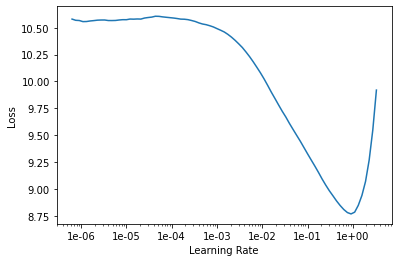

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('first', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.706532,3.680723,0.438822,27:01


In [ ]:
learn.load('first', with_opt=True)

In [26]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('second', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.382129,3.559769,0.445537,27:10
1,3.327420,3.447799,0.455460,27:11


Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.load('second', with_opt=True)

In [34]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))
learn.save('third', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,2.609991,2.767922,0.535434,27:14


In [38]:
np.exp(2.767922)

15.92550639982908

In [ ]:
TEXT = "ఇది మండల కేంద్రమైన రంపచోడవరం నుండి"
N_WORDS = 20
N_SENTENCES = 2

In [40]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁2 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁గుంటూరు ▁నుండి ▁66 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .
ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁14 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁రాజమహేంద్రవరం ▁నుండి ▁69 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .


In [ ]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()


In [ ]:
!cp -r 'export.pkl' 'drive/My Drive/nlp-telugu/'

In [ ]:
defaults.device = torch.device('cpu')

In [56]:

learn = load_learner('./')

In [ ]:
encoder = get_model(learn.model)[0]

In [58]:

encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 400])

In [ ]:
embeddings = encoder.state_dict()['encoder.weight']

In [ ]:

embeddings = np.array(embeddings)

In [61]:
embeddings[0].shape

(400,)

In [ ]:
df = pd.DataFrame(embeddings)

In [63]:
df.shape

(25000, 400)

In [ ]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [65]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,0.099659,-0.621001,0.298894,-0.398870,0.370496,-0.562941,-0.215177,-0.799160,0.199650,-0.094268,0.418945,-0.012014,0.009480,0.218238,-0.271387,0.185172,0.342614,0.217284,-0.357803,-0.303433,-0.066666,-0.454427,-0.083955,-0.296106,-0.062908,0.292362,-0.242734,-0.200447,0.281813,0.250824,-0.306845,-0.371481,-0.581170,0.189073,0.685597,-0.334945,-0.621285,0.331789,0.001825,-0.335054,...,-0.237333,0.020626,0.063201,0.176917,-0.236801,0.170087,-0.018524,-0.173578,0.156423,0.064838,0.801235,-0.884376,-0.064233,0.061051,-0.681529,-0.077110,-0.082768,-0.304069,-0.393082,0.303890,0.197272,0.329425,-0.067870,-0.394466,-0.595276,0.260154,0.242977,-0.154355,0.359637,-0.057620,0.313168,-0.601302,0.058583,-0.314320,0.067223,0.167035,0.155598,-0.331815,0.457884,0.043010
1,-0.006485,-0.019785,0.108462,-0.054573,-0.151146,-0.101801,-0.016049,0.039561,0.179447,-0.050422,0.105648,0.077527,-0.095577,0.114359,-0.041774,0.360153,0.223183,-0.212290,-0.205241,-0.014968,-0.009712,0.055057,0.017554,-0.218021,-0.199137,0.126014,0.180775,0.100150,0.232905,0.006739,-0.122894,0.066246,0.083483,-0.013002,0.091546,-0.129276,0.180145,0.089959,-0.172883,-0.014331,...,-0.133095,0.013899,0.059594,0.083385,0.039359,-0.175715,0.207146,-0.123955,0.172619,-0.144926,0.207105,-0.059719,-0.197623,-0.006905,0.040045,0.248092,0.034833,-0.005096,-0.280740,-0.041872,0.166260,-0.173796,-0.083608,-0.052436,-0.132273,0.217469,-0.245596,-0.273993,0.252842,-0.059912,0.074374,-0.021531,-0.022696,-0.014436,0.178088,-0.593903,-0.375987,-0.279526,0.070401,0.026663
2,-0.006485,-0.019785,0.108462,-0.054573,-0.151146,-0.101801,-0.016049,0.039561,0.179447,-0.050422,0.105648,0.077527,-0.095577,0.114359,-0.041774,0.360153,0.223183,-0.212290,-0.205241,-0.014968,-0.009712,0.055057,0.017554,-0.218021,-0.199137,0.126014,0.180775,0.100150,0.232905,0.006739,-0.122894,0.066246,0.083483,-0.013002,0.091546,-0.129276,0.180145,0.089959,-0.172883,-0.014331,...,-0.133095,0.013899,0.059594,0.083385,0.039359,-0.175715,0.207146,-0.123955,0.172619,-0.144926,0.207105,-0.059719,-0.197623,-0.006905,0.040045,0.248092,0.034833,-0.005096,-0.280740,-0.041872,0.166260,-0.173796,-0.083608,-0.052436,-0.132273,0.217469,-0.245596,-0.273993,0.252842,-0.059912,0.074374,-0.021531,-0.022696,-0.014436,0.178088,-0.593903,-0.375987,-0.279526,0.070401,0.026663
3,0.406992,-0.587346,0.237078,0.939926,-0.184857,-0.355414,-0.104929,-0.264919,0.223994,-0.052871,0.332867,-0.100500,0.098060,0.138750,-0.036764,0.086516,0.449082,0.119517,-0.063119,0.029973,-1.039848,-0.007011,-0.251220,-0.377899,-0.032943,2.162202,0.853723,0.297321,0.352109,0.411266,0.031658,0.211647,-0.256962,-0.026936,0.035083,-0.150695,3.165294,0.008368,0.092211,-0.397060,...,-0.115071,0.066219,0.052974,0.107332,-0.017817,-0.171130,0.384995,-0.182978,-0.357016,-0.155515,-0.565625,-0.084091,-0.156413,-1.042084,-0.351843,-0.711394,0.512708,-0.264104,0.680784,0.000070,0.307541,-0.365046,0.197430,-0.153544,0.633746,0.810342,-0.186784,0.296997,-0.741429,0.055622,-0.083957,0.812501,0.019674,-0.072328,0.388331,-0.213139,-0.418918,-0.081481,0.215055,-0.023436
4,0.133606,-0.698306,0.171627,0.174112,-0.201022,-0.166220,0.067220,-0.217676,0.117506,0.312167,-0.092266,-0.219844,0.037448,0.037191,0.016086,-0.666805,-0.043875,0.729495,0.013647,-0.070028,-0.109173,-0.055379,0.165396,0.227350,0.169881,3.214084,0.788011,-0.027860,0.257684,0.011769,-0.161085,0.027542,-0.028125,0.077319,0.174815,0.087125,-0.098170,0.153875,-0.096502,-0.085941,...,-0.107911,-0.089479,0.010394,0.420857,-0.007904,-0.284876,-0.337460,-0.170445,-0.141904,-0.011028,-0.291612,0.134554,-0.250707,-0.595292,-0.139769,-0.096728,-0.114652,-0.122223,-0.237354,-0.144679,-0.027110,-0.135409,0.086003,-0.127145,0.164207,0.295226,-0.034850,0.421

In [66]:
df2 = pd.DataFrame(itos)
df2.shape

(25000, 1)

In [67]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [ ]:

df2.to_csv('embedding_metadata.tsv', sep='\t', index=False, header=False)

In [ ]:
!cp -r 'embedding_metadata.tsv' 'drive/My Drive/nlp-telugu/'